In [1]:
import pandas as pd

df = pd.read_csv("data/AI_Human.csv")
df = df.dropna()
df.head()

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


In [2]:
from datasets import load_dataset

ds = load_dataset("Hello-SimpleAI/HC3", "all")

/home/sneha/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Extract and label data
rows = []
for entry in ds["train"]:
    for a in entry["chatgpt_answers"]:
        rows.append({"text": a.strip(), "label": 0})  # AI
    for a in entry["human_answers"]:
        rows.append({"text": a.strip(), "label": 1})  # Human

df = pd.DataFrame(rows).dropna()
print(f"Samples: {len(df)}")

Samples: 85449


In [4]:

# Balance classes
min_class = df['label'].value_counts().min()
df_balanced = pd.concat([
    df[df['label'] == 0].sample(min_class),
    df[df['label'] == 1].sample(min_class)
]).sample(frac=1).reset_index(drop=True)

In [5]:
# Tokenization + Dataset Prep
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import torch

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

class HC3Dataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels

    def __len__(self): return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = HC3Dataset(df_balanced['text'].tolist(), df_balanced['label'].tolist(), tokenizer)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [8]:
# Train the RoBERTa Classifier
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

from transformers import AdamW
from tqdm import tqdm

optimizer = AdamW(model.parameters(), lr=2e-5)

model.train()
for epoch in range(3):
    total_loss = 0
    for batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"Epoch {epoch + 1} Loss: {total_loss:.4f}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/sneha/venv/lib/python3.8/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 6726/6726 [16:55<00:00,  6.62it/s]


Epoch 1 Loss: 140.2325


100%|██████████| 6726/6726 [14:55<00:00,  7.51it/s]


Epoch 2 Loss: 56.9258


100%|██████████| 6726/6726 [14:54<00:00,  7.52it/s]

Epoch 3 Loss: 54.3202


In [5]:
model.save_pretrained("initial-roberta-ai-detector")
tokenizer.save_pretrained("initial-roberta-ai-detector")

NameError: name 'model' is not defined

In [5]:
from transformers import RobertaForSequenceClassification

# Load model and tokenizer from the saved directory
model = RobertaForSequenceClassification.from_pretrained("initial-roberta-ai-detector").to(device)
tokenizer = RobertaTokenizer.from_pretrained("initial-roberta-ai-detector")

# Predict
model.eval()
preds = []

In [20]:
import os
import jsonlines
import torch
from sklearn.metrics import classification_report
from transformers import RobertaTokenizer
from tqdm import tqdm

dev_dir = "cs162-final-dev-main"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
human_texts, machine_texts = [], []

for filename in os.listdir(dev_dir):
    if filename.endswith(".jsonl"):
        file_path = os.path.join(dev_dir, filename)
        with jsonlines.open(file_path) as reader:
            for row in reader:
                human_texts.append(row["human_text"])
                machine_texts.append(row["machine_text"])

test_texts = human_texts + machine_texts
true_labels = [1] * len(human_texts) + [0] * len(machine_texts)

# Load tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Predict
model.eval()
preds = []

with torch.no_grad():
    for i in tqdm(range(0, len(test_texts), 8)):
        batch = test_texts[i:i+8]
        encodings = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=256)
        input_ids = encodings["input_ids"].to(device)
        attention_mask = encodings["attention_mask"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        batch_preds = torch.argmax(outputs.logits, dim=1).tolist()
        preds.extend(batch_preds)

# Evaluate
from sklearn.metrics import classification_report

print(classification_report(true_labels, preds, target_names=["AI-generated", "Human-written"]))

100%|██████████| 3000/3000 [02:13<00:00, 22.43it/s] 

               precision    recall  f1-score   support

 AI-generated       0.00      0.00      0.00     12000
Human-written       0.50      1.00      0.67     12000

     accuracy                           0.50     24000
    macro avg       0.25      0.50      0.33     24000
 weighted avg       0.25      0.50      0.33     24000




/home/sneha/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sneha/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sneha/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


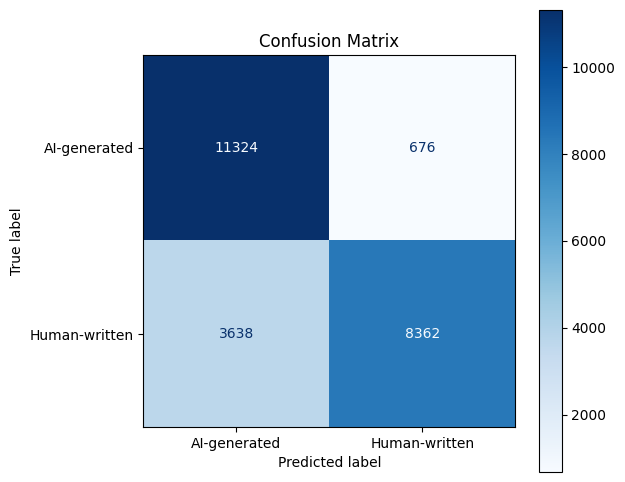

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["AI-generated", "Human-written"])

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

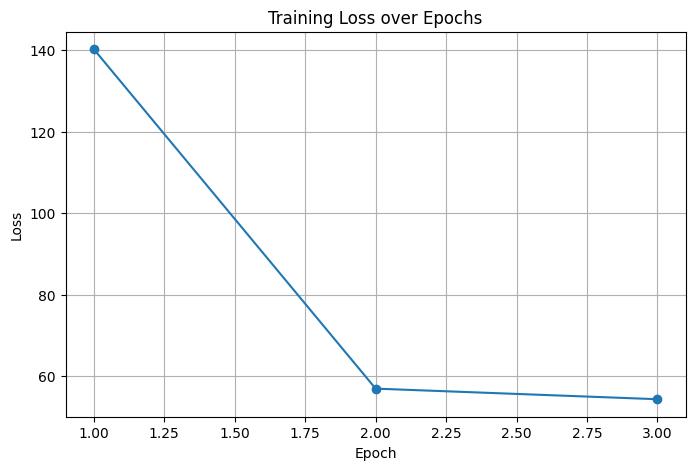

In [9]:
training_losses = [140.23, 56.92, 54.32]
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(training_losses) + 1), training_losses, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [6]:
import torch
from transformers import RobertaForSequenceClassification, RobertaTokenizer, AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load model and move to device
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Track batch losses
batch_losses = []

# Training loop
model.train()
num_epochs = 5  # increase to see clearer trends
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    for batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        batch_losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/sneha/venv/lib/python3.8/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/5


100%|██████████| 6726/6726 [17:12<00:00,  6.51it/s]



Epoch 2/5


100%|██████████| 6726/6726 [15:41<00:00,  7.14it/s]



Epoch 3/5


100%|██████████| 6726/6726 [15:42<00:00,  7.14it/s]



Epoch 4/5


100%|██████████| 6726/6726 [15:44<00:00,  7.12it/s]



Epoch 5/5


100%|██████████| 6726/6726 [15:43<00:00,  7.13it/s]
